## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import  StandardScaler,OneHotEncoder,MinMaxScaler, RobustScaler
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats
from scipy.stats import norm
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline 
from lightgbm import LGBMClassifier
from sklearn.utils import resample
import category_encoders as ce
import itertools
import pickle

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.base import clone




import warnings
warnings.filterwarnings('ignore')


Loading train and test sets and concatinating to do analysis on overall data

## Exploratory Data Analysis

In [3]:
train = pd.read_csv('/Users/ulvijafarli/Kaggle/trade_republic/tr_fincrime_train.csv')

test = pd.read_csv('/Users/ulvijafarli/Kaggle/trade_republic/tr_fincrime_test.csv')

In [4]:
#Adding set type column to differentiate train/test data sets in concatinated data set
train['set_type'] = 'train'
test['set_type'] = 'test'

In [5]:
all_data = pd.concat([train, test], axis = 0)

In [6]:
#dropping unnessary column
all_data  = all_data.drop(['Unnamed: 0'],axis=1)

In [7]:
all_data[all_data['is_fraud']==1].count()

trans_date_trans_time    9651
cc_num                   9651
merchant                 9651
category                 9651
amt                      9651
first                    9651
last                     9651
gender                   9651
street                   9651
city                     9651
state                    9651
zip                      9651
lat                      9651
long                     9651
city_pop                 9651
job                      9651
dob                      9651
trans_num                9651
unix_time                9651
merch_lat                9651
merch_long               9651
is_fraud                 9651
set_type                 9651
dtype: int64

As you can see there total of 9651 fradulent transactions

In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
 22  set_type           

In [9]:
all_data.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
set_type                 0
dtype: int64

Transaction date and date of birth columns have object data type and they will be converted into date type in the below cell and there are no missing values in the dataset

In [10]:
all_data['trans_date_trans_time'] = pd.to_datetime(all_data['trans_date_trans_time'])

all_data['dob'] = pd.to_datetime(all_data['dob'])


In [11]:
all_data.shape

(1852394, 23)

### Part 1

## Some business Insights from the overall data


In [12]:
all_data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,set_type
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train


Lets do feature engineering by getting hourly data see transaction distribution within days

In [13]:
all_data['hour'] = all_data['trans_date_trans_time'].dt.hour

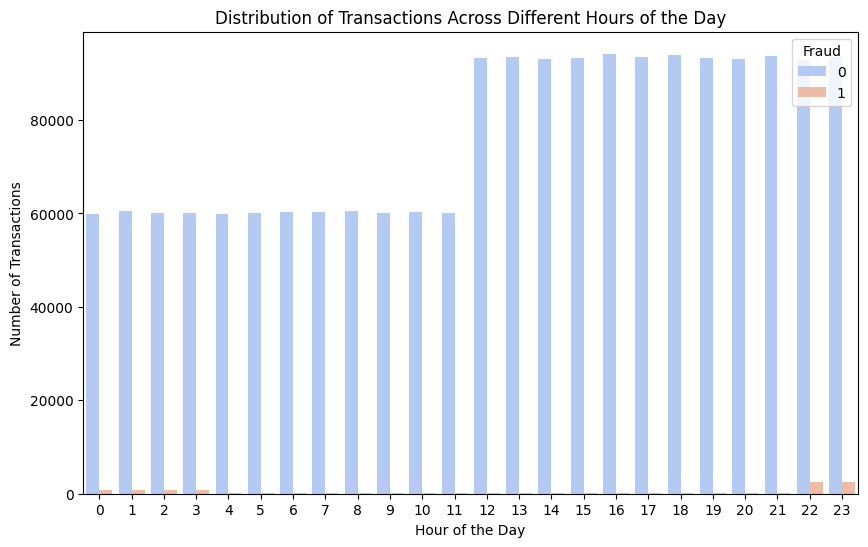

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=all_data, x='hour', hue='is_fraud', palette='coolwarm')
plt.title('Distribution of Transactions Across Different Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.legend(title='Fraud', loc='upper right')
plt.show()

From above we can see that fraudulent transactions are more frequent during specific hours of the day, particularly during late hours and early hours of the day. This suggests that fraudsters might be exploiting times when users are less likely to notice suspicious activity, such as late at night or early morning. It would be good idea to to implement addtional monitoring or verification for transactions that occuring during high-risk hours

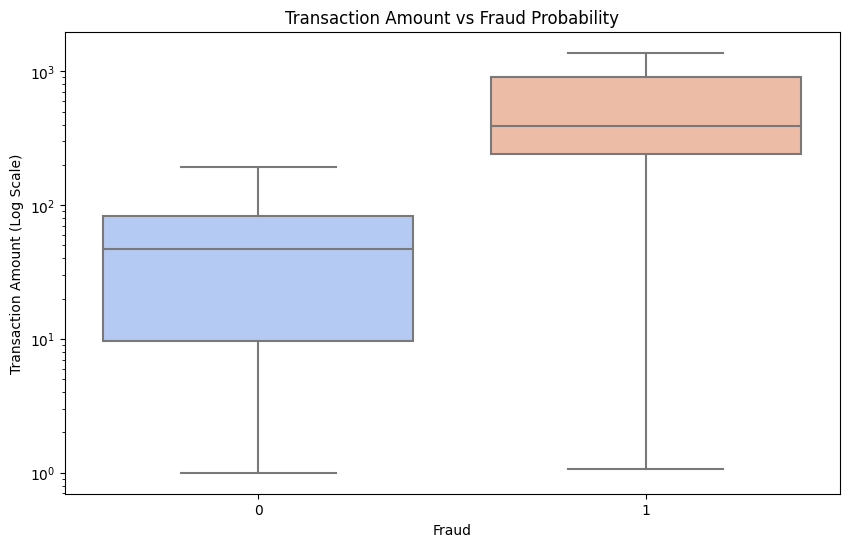

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=all_data, palette='coolwarm', showfliers=False)
plt.yscale('log')
plt.title('Transaction Amount vs Fraud Probability')
plt.xlabel('Fraud')
plt.ylabel('Transaction Amount (Log Scale)')
plt.show()


Higher transaction amounts have a stronger association with fraudulent activities, though fraud occurs across a wide range of transcation amounts. It may be better to consider implementing stricter verification (i.e additional evaluee) processes for higher-value transactions to mitigate fraud risks

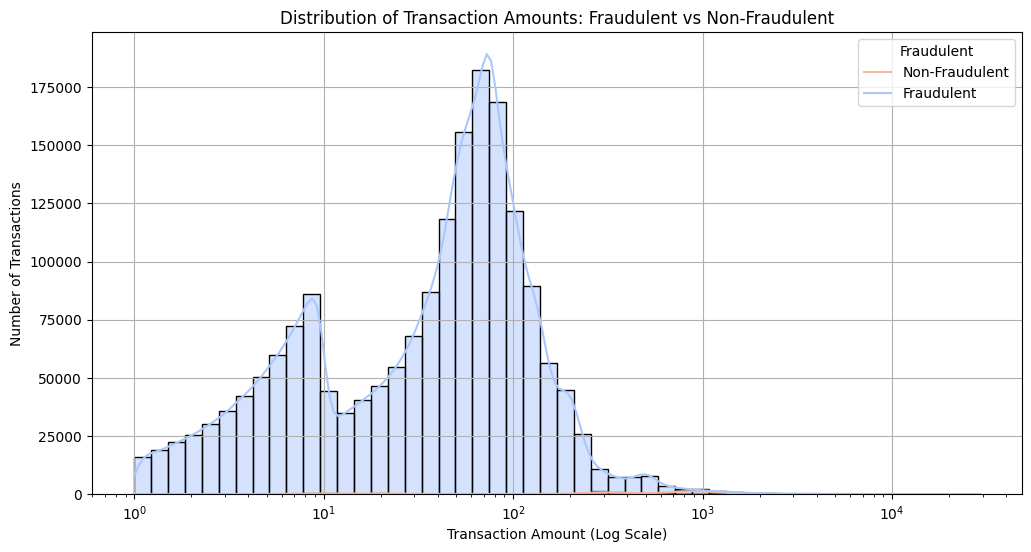

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(data=all_data, x='amt', hue='is_fraud', bins=50, kde=True, palette='coolwarm', log_scale=True)
plt.title('Distribution of Transaction Amounts: Fraudulent vs Non-Fraudulent')
plt.xlabel('Transaction Amount (Log Scale)')
plt.ylabel('Number of Transactions')
plt.legend(title='Fraudulent', labels=['Non-Fraudulent', 'Fraudulent'])
plt.grid(True)
plt.show()

There are fewer high-value (amount) transactions overall, but within this range, the distinction between fraudulent and non-fraudulent transactions becomes more apparent. Monitoring these transactions closely might be beneficial

Below function will calculate distance between merchant and customer coordinates to understan relationship between customer/merchant location and fradulent activity

In [17]:
#distance function between merchant and customer 

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371  # Radius of earth in kilometers
    return c * r

In [18]:
#adding distance column to the data
all_data['distance']=haversine(all_data['lat'], all_data['long'], all_data['merch_lat'], all_data['merch_long'])

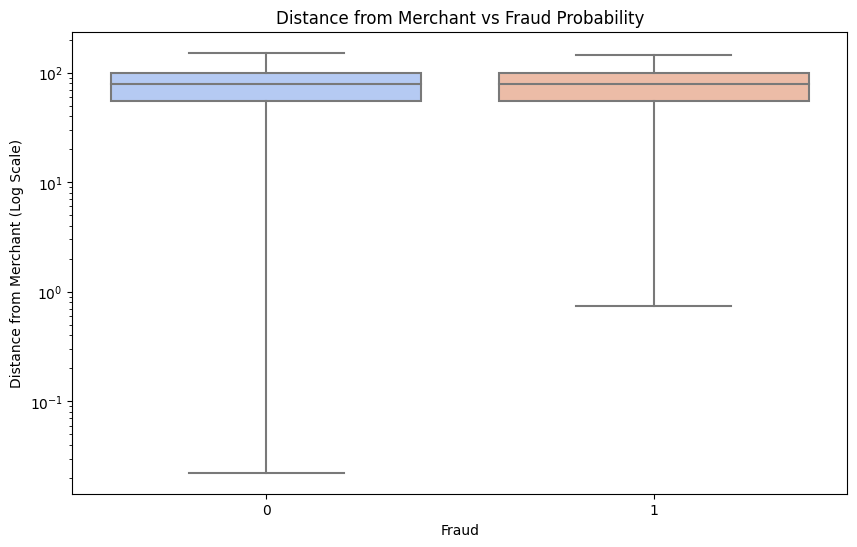

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='distance', data=all_data, palette='coolwarm', showfliers=False)
plt.yscale('log')
plt.title('Distance from Merchant vs Fraud Probability')
plt.xlabel('Fraud')
plt.ylabel('Distance from Merchant (Log Scale)')
plt.show()

Fraud is more likely when there is a significant distance between the customer's registered location and the merchant's location. It would be good idea to introduce a risk score based on the geographic distance between the transaction location and the customer's home location, flagging transactions that occur far from the expected area.

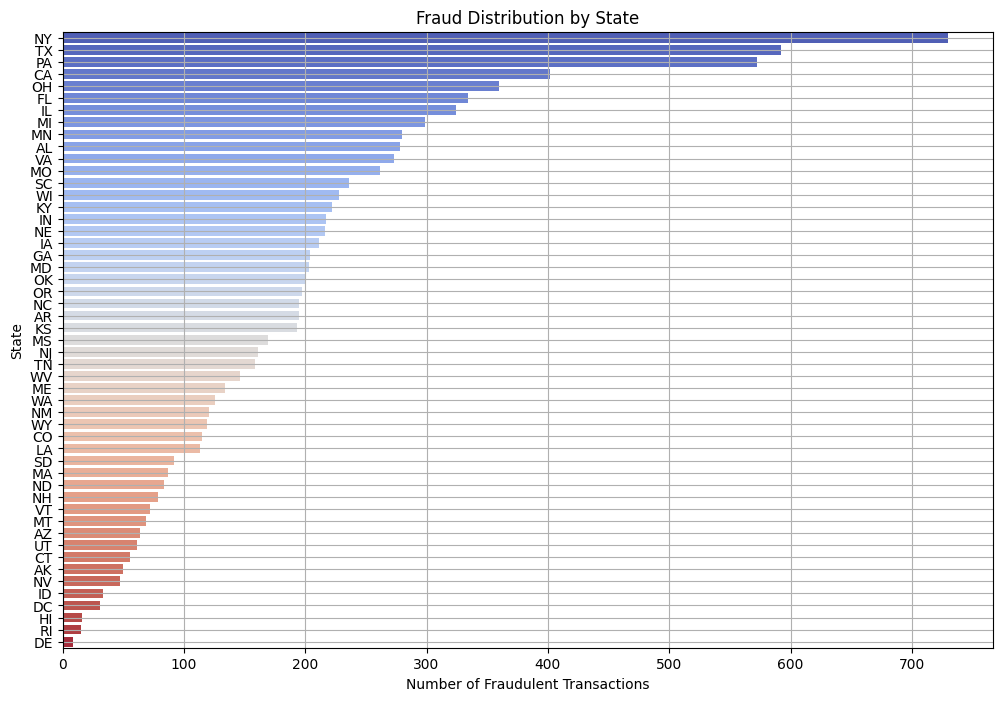

In [20]:
plt.figure(figsize=(12, 8))
fraud_by_state = all_data[all_data['is_fraud'] == 1]['state'].value_counts().sort_values(ascending=False)
sns.barplot(x=fraud_by_state.values, y=fraud_by_state.index, palette='coolwarm')
plt.title('Fraud Distribution by State')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('State')
plt.grid(True)
plt.show()


Fraudulent transactions are concentrated in certain states (i.e NY, TX,PA, CA) more than others. This could indicate regional vulnerabilities or targeted attacks so as a precaution focusing on improving security and monitoring efforts in states with higher fraud rates would mitigate fraud risks. 

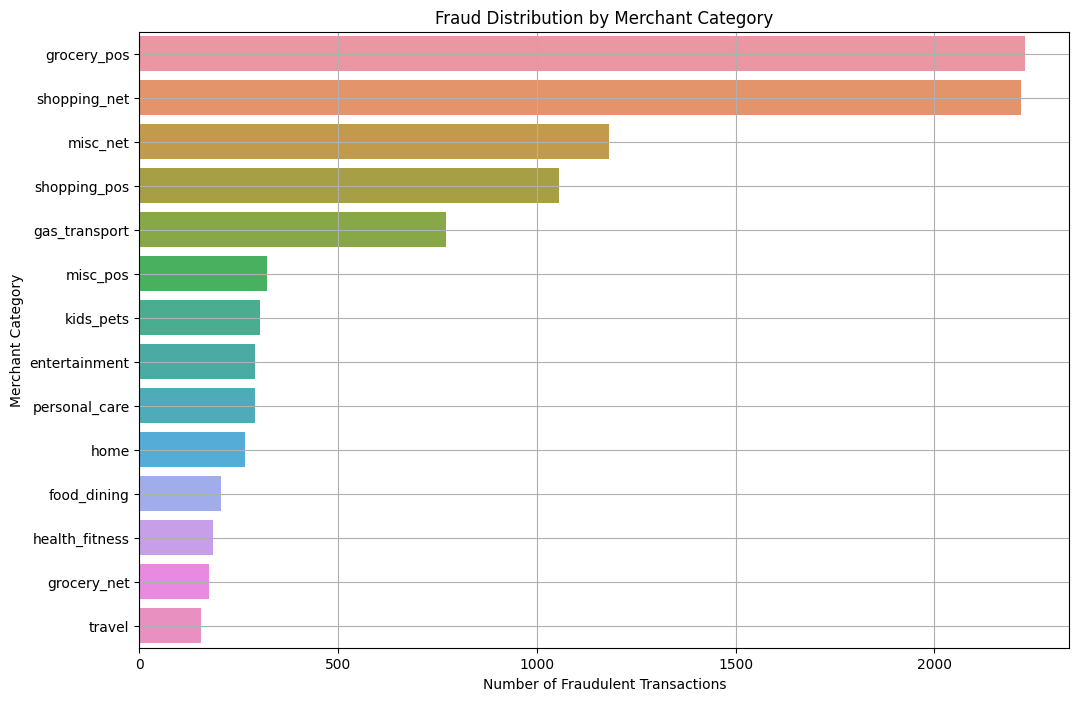

In [21]:
plt.figure(figsize=(12, 8))
fraud_by_category = all_data[all_data['is_fraud'] == 1]['category'].value_counts().sort_values(ascending=False)
sns.barplot(x=fraud_by_category.values, y=fraud_by_category.index)
plt.title('Fraud Distribution by Merchant Category')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Merchant Category')
plt.grid(True)
plt.show()

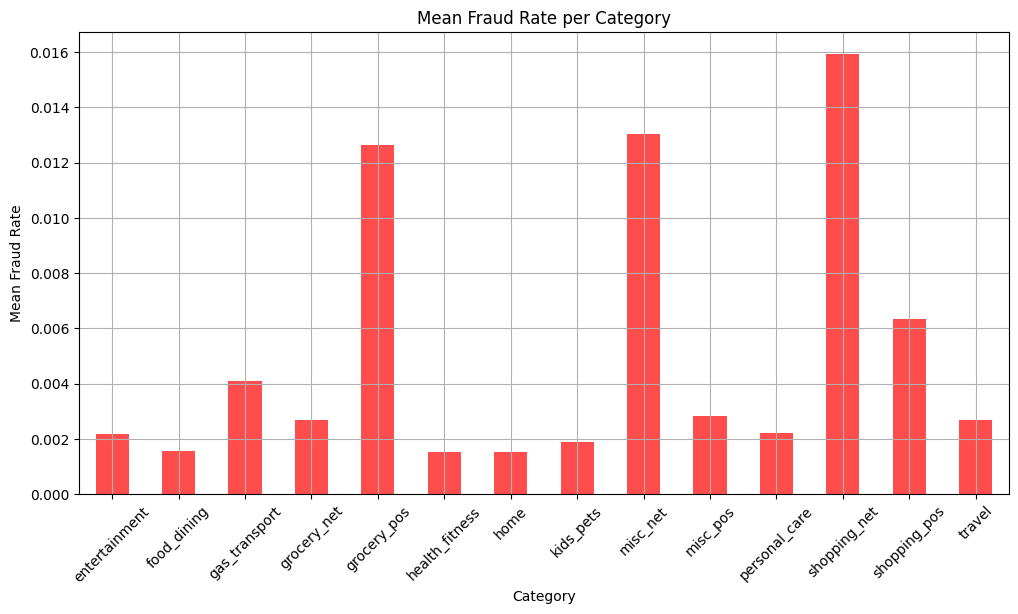

In [22]:
mean_values_per_category = all_data.groupby('category')[['amt', 'is_fraud']].mean()

plt.figure(figsize=(12, 6))
mean_values_per_category['is_fraud'].plot(kind='bar', color='red', alpha=0.7)
plt.title('Mean Fraud Rate per Category')
plt.xlabel('Category')
plt.ylabel('Mean Fraud Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Certain  categories are more prone to fraudulent transactions. The both bar plot shows that specific categories like "grocery pos","misc_net" and "shopping_net" have a higher number of fraudulent transactions or mean fraud rate that mostly targeted by fraudsters. Fitness, food_dining and home categories are least attacked cateogries by merchants

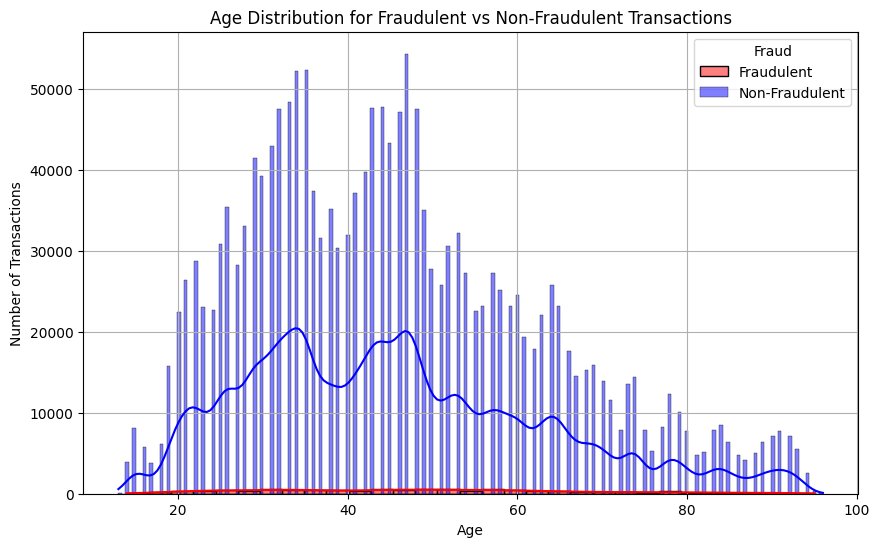

In [23]:
all_data['age'] = (all_data['trans_date_trans_time'] - all_data['dob']).astype('timedelta64[Y]')

plt.figure(figsize=(10, 6))
sns.histplot(all_data[all_data['is_fraud'] == 1]['age'], kde=True, color='red', label='Fraudulent')
sns.histplot(all_data[all_data['is_fraud'] == 0]['age'], kde=True, color='blue', label='Non-Fraudulent')
plt.title('Age Distribution for Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.legend(title='Fraud')
plt.grid(True)
plt.show()

The age distribution plot indicates that fraud is more frequent among certain age groups. Younger customers tend to have a slightly higher incidence of fraud compared to older customers. 

I will drop dob feature and use age feature from now on as it will be more convenient to use for modelling 

In [24]:
all_data.drop('dob', inplace=True, axis=1)

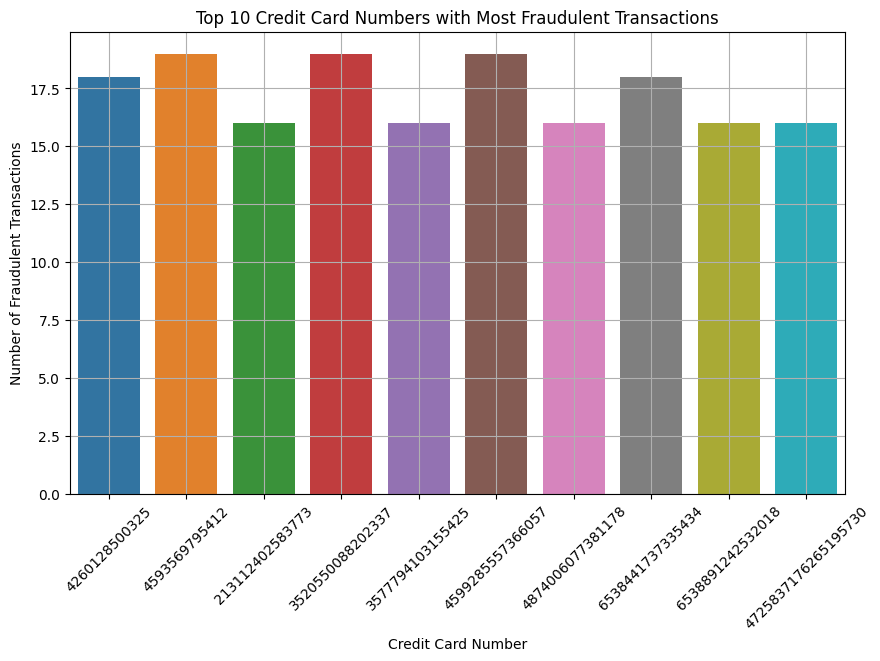

In [25]:
top_fraudulent_cc = all_data[all_data['is_fraud'] == 1]['cc_num'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_fraudulent_cc.index, y=top_fraudulent_cc.values)
plt.title('Top 10 Credit Card Numbers with Most Fraudulent Transactions')
plt.xlabel('Credit Card Number')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Above plot highlights the top 10 credit card numbers that have experienced the highest number of fraudulent transactions. This indicates that certain cards are being repeatedly targeted or compromised. These credit card numbers should be flagged for immediate investigation, and potentially blocked or monitored more closely.

## Part 2

Before building prediction model lets check if the data is imbalanced and we need to treat it as a time series data set (i.e has temporal aspect)

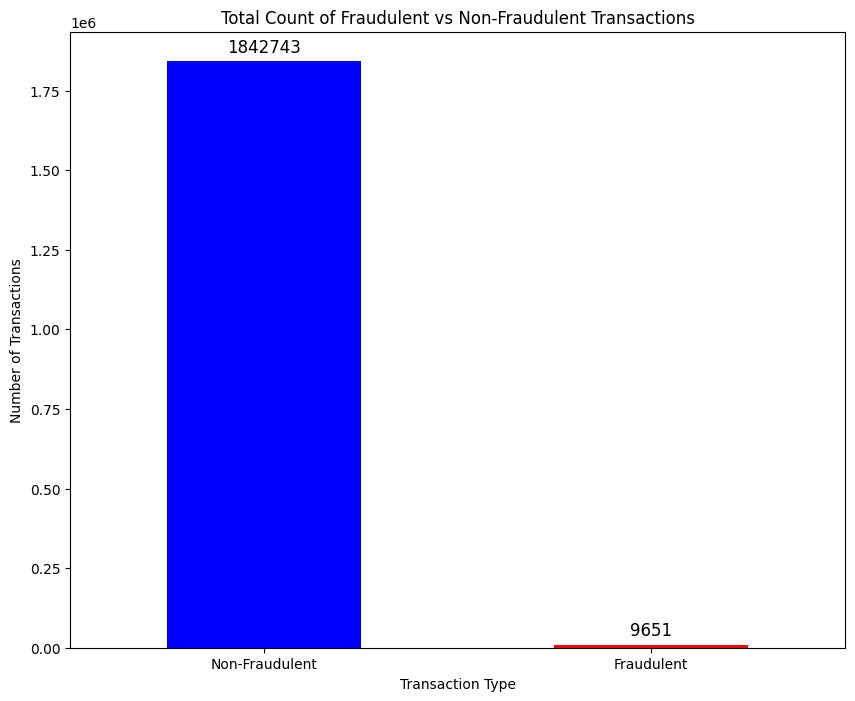

In [26]:
fraud_counts = all_data['is_fraud'].value_counts()

plt.figure(figsize=(10, 8))
ax = fraud_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Total Count of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'], rotation=0)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, color='black')

plt.grid(False)
plt.show()

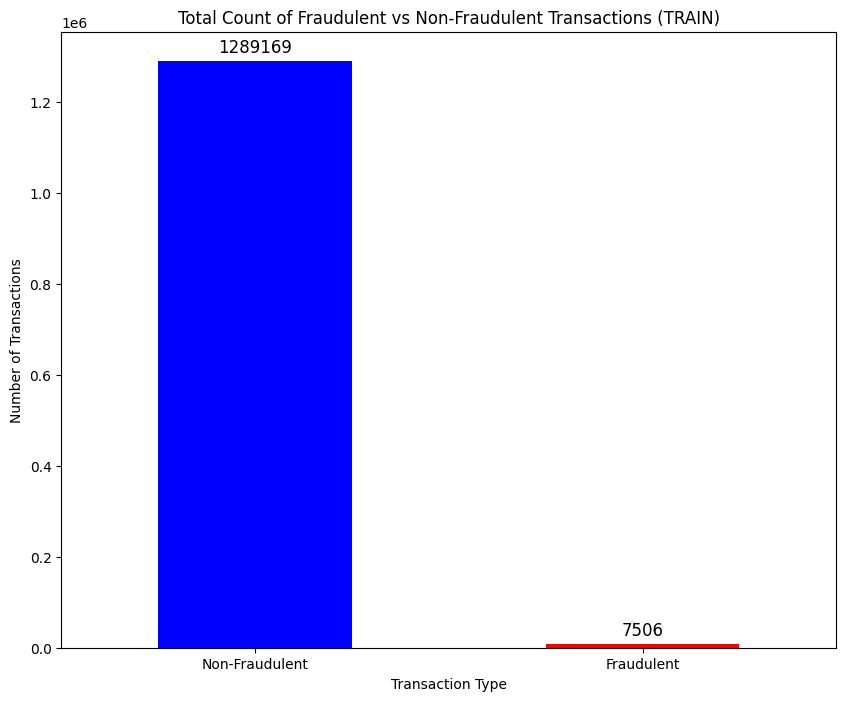

In [27]:
fraud_counts = all_data[all_data['set_type']=='train']['is_fraud'].value_counts()

plt.figure(figsize=(10, 8))
ax = fraud_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Total Count of Fraudulent vs Non-Fraudulent Transactions (TRAIN)')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'], rotation=0)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, color='black')

plt.grid(False)
plt.show()

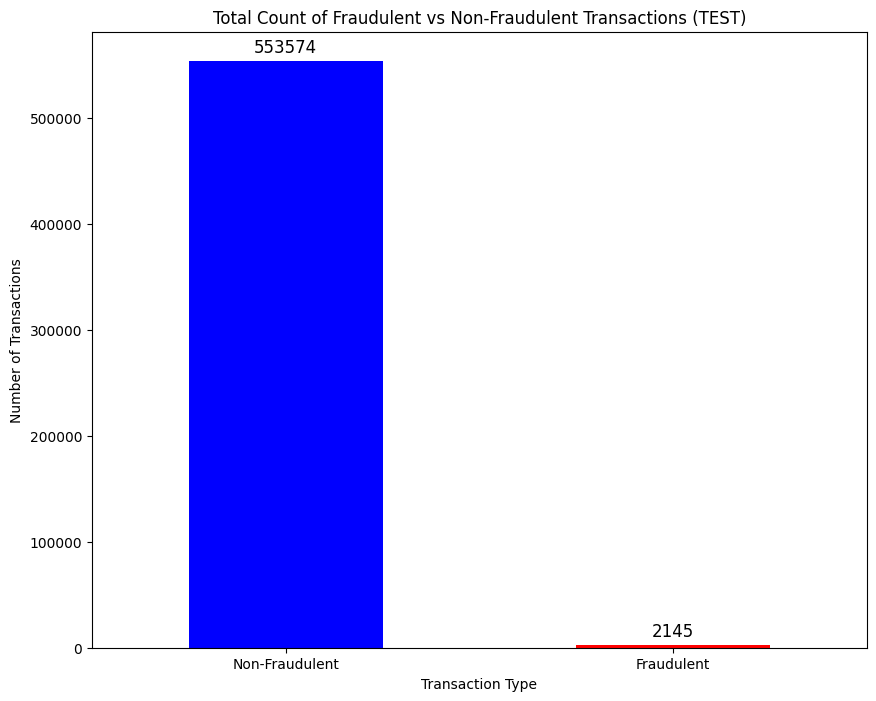

In [28]:
fraud_counts = all_data[all_data['set_type']=='test']['is_fraud'].value_counts()

plt.figure(figsize=(10, 8))
ax = fraud_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Total Count of Fraudulent vs Non-Fraudulent Transactions (TEST)')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'], rotation=0)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, color='black')

plt.grid(False)
plt.show()

From bar plots we can see that training and test data sets  are imbalanced with 99.4% with transactions being non-fradulent and only 0.6% being fradulent. This significant imbalance will be addressed during model training, through techniques SMOTE (i.e will creata) and RandomUndersampling to ensure the model can effectively detect fraudulent transactions

Lets see if provided data sets have temproal aspect, meaning if there are any repeated pattern in terms of overall and fradulent transactions

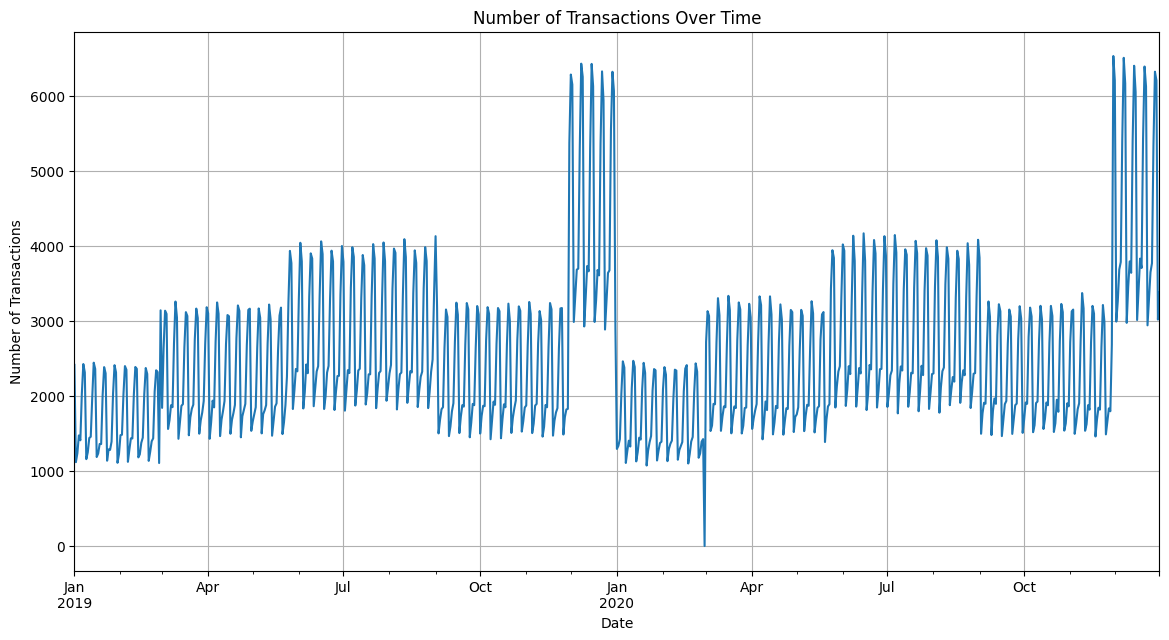

In [29]:
plt.figure(figsize=(14, 7))
all_data.set_index('trans_date_trans_time')['is_fraud'].resample('D').count().plot()
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

The plot of the number of transactions over time (daily) indicates that the data has a temporal aspect. During specific day of each month we can see clear spike pattern in number of transactions. 

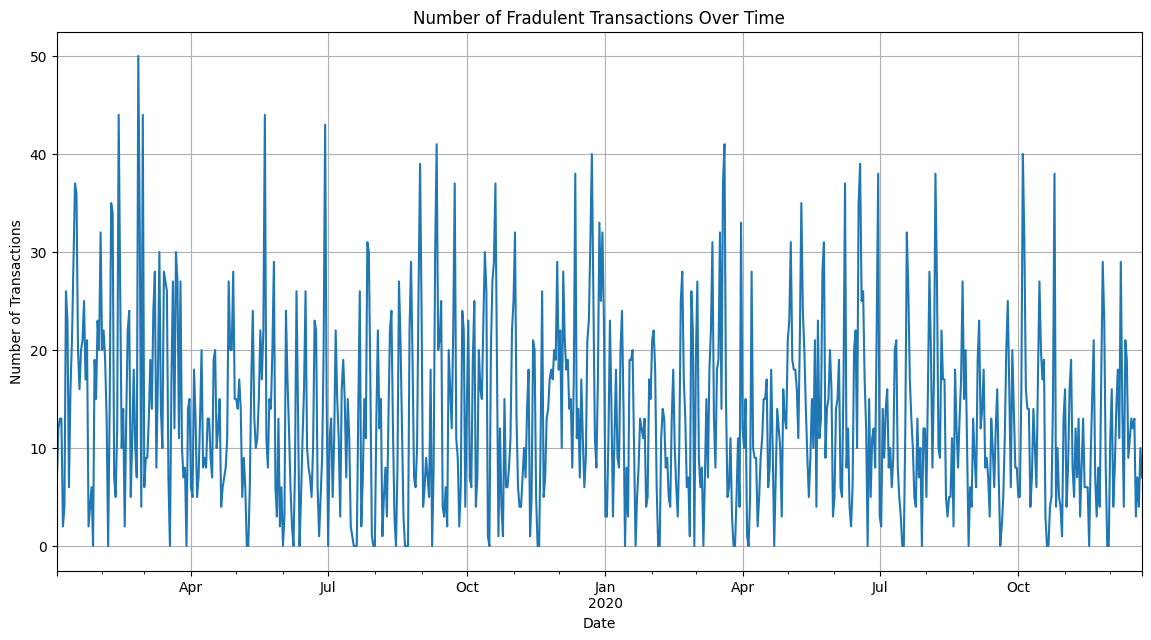

In [30]:
df_fraud = all_data[all_data['is_fraud']==1]
plt.figure(figsize=(14, 7))
df_fraud.set_index('trans_date_trans_time')['is_fraud'].resample('D').count().plot()
plt.title('Number of Fradulent Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

We can also see clear temporal pattern in fradulent transactions as certain same days of the month and cetrain same months of the year we can same spikes in fradulent transactions

Lets check correlaiton between independent variables and between independt variables and target (i.e 'is_fraud')


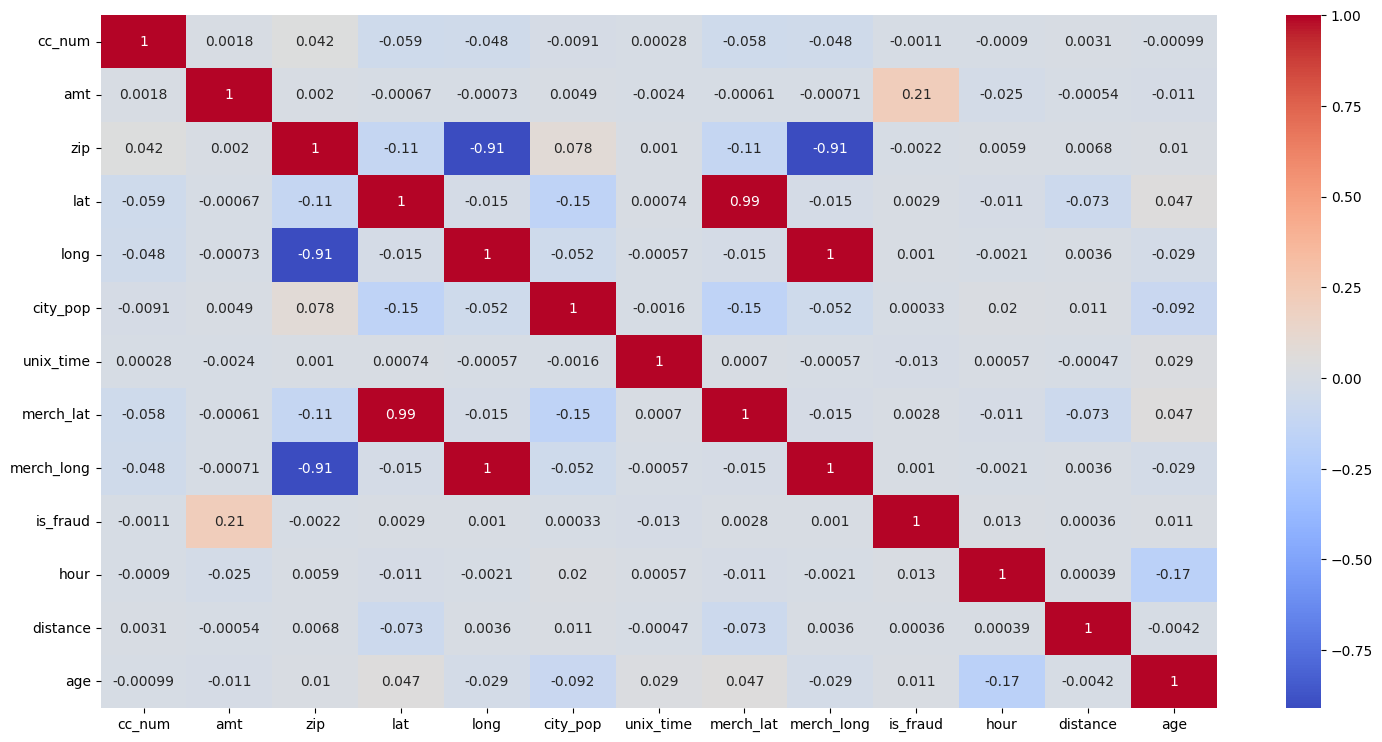

In [31]:
fig = plt.figure(figsize=(18,9))
sns.heatmap(all_data.corr(),cmap='coolwarm', annot=True)
plt.show()

From the heatmap, we can see that there is no visible correlation between variables, except weak positive correlation between amount and is_fraud. 

 Lets check cardinality of the categorical variables since we have very hugh training and test data
 

In [32]:
cat_cols = all_data.select_dtypes(include='object').columns 

for col in cat_cols: 
    all_data[col] = all_data[col].str.lower().str.strip()

all_data[cat_cols].nunique().sort_values()

gender             2
set_type           2
category          14
state             51
first            355
last             486
job              497
merchant         693
city             906
street           999
trans_num    1852394
dtype: int64

As you can see there are some categories (i.e street, city,job,merchant,trans_num etc ) that highly cardinal which will increase dimennsionality of the dataset, eventully might lead to overfitting when converted to numerical variables using encoding techniques.  it will also be computationally expensive. It would be safe drop them since they do not have direct impact on target variable which is predicting fraud/or not 

In [33]:
cols_to_drop = ['street','merchant','zip','first','last','trans_num','job','city'] 

all_data.drop(cols_to_drop, axis = 1, inplace=True)


In [34]:
all_data[all_data.select_dtypes(include='object').columns ].nunique().sort_values()

gender       2
set_type     2
category    14
state       51
dtype: int64

## Feature Engineering

since there are some temporal aspeck in the data, I will engineer new features such as 'dayofweek' and 'month' and add them to the data set as they will also have some contribution to fraud prediction 

In [35]:
all_data['day_of_week'] = all_data['trans_date_trans_time'].dt.dayofweek
all_data['month'] = all_data['trans_date_trans_time'].dt.month

Lets create additional features by calculating lat and long distance between merchant and customer and between current merchant and previous merchant as we saw earlier fradulent transactions tend to occur when distance between merchant and customer bigger so having them in the model would help us to predict fradulent transactions. as we already have these features in the dataset, we can drop distance feature from data set 

In [36]:
all_data['lat_dist_cust_merch'] = (all_data['lat'] - all_data['merch_lat']).abs()
all_data['long_dist_cust_merch'] = (all_data['long'] - all_data['merch_long']).abs()

all_data = all_data.drop('distance',axis=1)

I will now split overall dataset into train and test so I can do further analysis and build models on training data and use test data to evaluate the models

In [37]:
df_train = all_data[all_data['set_type']=='train']
df_test = all_data[all_data['set_type']=='test']

df_train.drop(['set_type'], inplace=True, axis=1)
df_test.drop(['set_type'], inplace=True, axis=1)

I will do additioanl feature engineering considering there are temproal aspect in the transactions. Lets check transactions per card number again

In [38]:
df_train.groupby(['cc_num'])['cc_num'].count().sort_values(ascending = False).describe().astype(int)


count     983
mean     1319
std       812
min         7
25%       525
50%      1054
75%      2025
max      3123
Name: cc_num, dtype: int64

From the output, we can see there are total of 983 transactions and each card has been used several times with 3123 maximum and  1319 times on average. so it would benefical to add feature that related delay betweem the previouse transaction and the current transaction. I will use unix time featuere for that which is the date and time representation widely used in computing. It measures time by the number of seconds that have elapsed since 00:00:00 UTC on 1 January 1970, the beginning of the Unix (Unix OS) epoch.

In [39]:
#creating previus transaction feature using shift 
df_train['unix_time_prev_trans'] = df_train.groupby(by=['cc_num'])['unix_time'].shift(1)

#filling na values using current transaction time - numbers of second in a day
df_train['unix_time_prev_trans'].fillna(df_train['unix_time'] - 86400, inplace = True)

#calculating lag value between transactions and adding it as a featuere
df_train['transaction_lag'] = (df_train['unix_time'] - df_train['unix_time_prev_trans'])//60


In the below two cells, I will also create additional lag features between merchants using shift method

In [40]:
#previus merch lat/long
df_train['prev_merch_lat'] = df_train.groupby(by = ['cc_num'])['merch_lat'].shift(1) 
df_train['prev_merch_long'] = df_train.groupby(by = ['cc_num'])['merch_long'].shift(1) 

df_train['prev_merch_lat'].fillna(df_train['merch_lat'], inplace = True)
df_train['prev_merch_long'].fillna(df_train['merch_long'], inplace = True)

#distance between current and previous merchant in terms lat/long coordinates
df_train['long_dist_prev_merch'] = (df_train['merch_long'] -df_train['prev_merch_long']).abs()
df_train['lat_dist_prev_merch'] = (df_train['merch_lat'] - df_train['prev_merch_lat']).abs()

So we created additional features, we can remove original features that used for them

In [41]:
cols_to_drop_2 = ['trans_date_trans_time','cc_num','unix_time', 'unix_time_prev_trans','lat','long','merch_lat','merch_long', 'prev_merch_lat','prev_merch_long']


df_train.drop(cols_to_drop_2, axis=1, inplace=True)

In [42]:
df_train.head()

,category,amt,gender,state,city_pop,is_fraud,hour,age,day_of_week,month,lat_dist_cust_merch,long_dist_cust_merch,transaction_lag,long_dist_prev_merch,lat_dist_prev_merch
0,misc_net,4.97,f,nc,3495,0,0,30.0,1,1,0.067507,0.870215,1440.0,0.0,0.0
1,grocery_pos,107.23,f,wa,149,0,0,40.0,1,1,0.271247,0.024038,1440.0,0.0,0.0
2,entertainment,220.11,m,id,4154,0,0,56.0,1,1,0.969904,0.107519,1440.0,0.0,0.0
3,gas_transport,45.00,m,mt,1939,0,0,51.0,1,1,0.803731,0.447271,1440.0,0.0,0.0
4,misc_pos,41.96,m,va,99,0,0,32.0,1,1,0.254299,0.830441,1440.0,0.0,0.0


## Outlier Check

In the below cells, I will try to find out if there are any anomilies (outlier) in terms of transaction amount for fradulent/not fradulent transactions

In [43]:
def plot_box (data, x, y, title , width = 10, height = 7):
  
  plt.figure(figsize = [width,height])
  sns.boxplot(data = data, x = x, y = y)
  plt.title(title)

In [44]:
def stats_by_target (variable):
  stat_grid = all_data.groupby('is_fraud')[variable].agg([np.min,np.max,np.mean,np.median])
  stat_grid = stat_grid.transpose().round(2)
  return stat_grid

is_fraud,0,1
amin,1.00,1.06
amax,28948.90,1376.04
mean,67.65,530.66
median,47.24,390.00


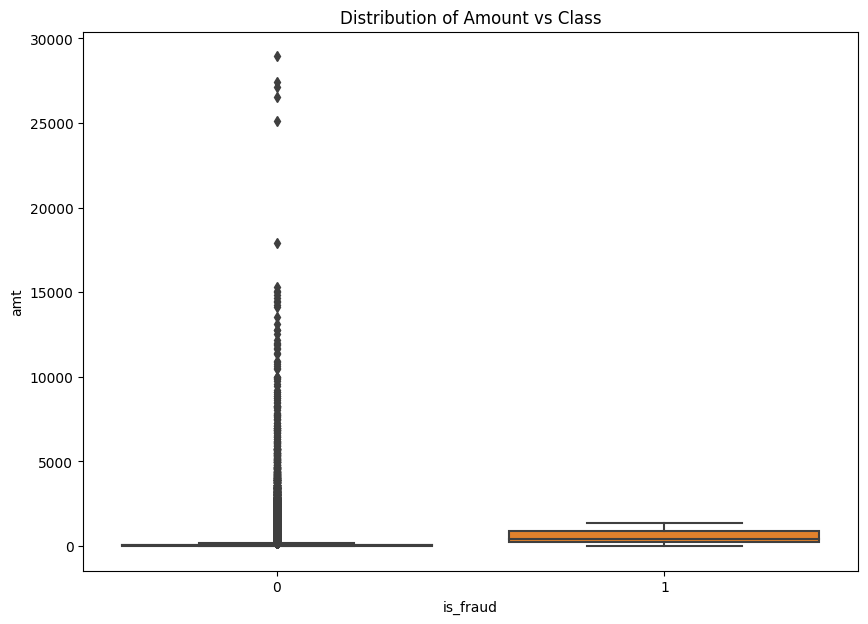

In [45]:
plot_box(df_train,'is_fraud','amt','Distribution of Amount vs Class')

stats_by_target('amt') 

As you can see above, there is no outlier in terms of amount for fradulent transactions, but most of the transaction are around 390 euros which is very high from normal transactions. The mean value of the fradulent transactions is also high with 530 euros compared to non-fradulent transaction which is 68 euros. 

we can see some outliers in the non fradulent transactions but I will not remove them since they might carry valuable information in terms of segregating fraduelent transactions from non-fradulent transactions

## Modelling

Lets split train data into into indepedent and dependent variables


In [46]:
X_train = df_train.drop('is_fraud', axis = 1)
y_train = df_train['is_fraud'] 

In [47]:
X_train

,category,amt,gender,state,city_pop,hour,age,day_of_week,month,lat_dist_cust_merch,long_dist_cust_merch,transaction_lag,long_dist_prev_merch,lat_dist_prev_merch
0,misc_net,4.97,f,nc,3495,0,30.0,1,1,0.067507,0.870215,1440.0,0.000000,0.000000
1,grocery_pos,107.23,f,wa,149,0,40.0,1,1,0.271247,0.024038,1440.0,0.000000,0.000000
2,entertainment,220.11,m,id,4154,0,56.0,1,1,0.969904,0.107519,1440.0,0.000000,0.000000
3,gas_transport,45.00,m,mt,1939,0,51.0,1,1,0.803731,0.447271,1440.0,0.000000,0.000000
4,misc_pos,41.96,m,va,99,0,32.0,1,1,0.254299,0.830441,1440.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,entertainment,15.56,m,ut,258,12,58.0,6,6,0.876234,0.786935,279.0,0.158495,0.999618
1296671,food_dining,51.70,m,md,100,12,40.0,6,6,0.359819,0.736428,132.0,0.558364,0.736832
1296672,food_dining,105.93,m,nm,899,12,52.0,6,6,0.679913,0.688371,484.0,1.448579,1.031726
1296673,food_dining,74.90,m,sd,1126,12,39.0,6,6,0.563660,0.700060,1516.0,1.321211,0.460062


Since data is highly imbalanced with only 0.6% of transaction being fradulent, encoding, transformation, scaling can get hugly biased by the train dataset. The prediction models will also be biased and mostly likely will not be able to segregate fradulent/non fradulent transactions. So in order to avoid that, I will resample dataset with SMOTE and RandomUndersampler techniques while doing scaling and cross-validation. 

I use SMOTE followed by random undersampling because it balances the dataset more effectively. SMOTE increases the minority class size (i.e fraud), and undersampling then reduces the majority class (no fraud) to a comparable level. This combined approach helps to prevent the model from overfitting to the minority class or being overwhelmed by the majority class.

I will first create function below to scale independent variables using RobustScaler for numerical since it is more robust to outliers, using TargetEncoder for high cardinality categorical feature (i.e 51 states) and OneHotEncoding using low-cardinaltiy categorical variables (gender, category)

In [97]:
def transformer(X,y):
    
    numerical_cols = X.select_dtypes(include = np.number).columns
    one_hot_cols = ['gender', 'category']
    target_encode_cols = ['state']


    numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Preprocessing for categorical data using OneHotEncoder
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

    target_encoder = ce.TargetEncoder(cols=target_encode_cols)


# Combine preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer( transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer,one_hot_cols),
        ('target',target_encoder, target_encode_cols)
    ])


# Fit and transform the data using the preprocessor
    X_preprocessed = preprocessor.fit_transform(X,y)
    
    try:
        with open('preprocessor.pkl', 'wb') as f:
            pickle.dump(preprocessor, f)
        print("Preprocessor saved successfully!")
    except Exception as e:
        print(f"Error occurred while saving preprocessor: {e}")

    all_columns = list(numerical_cols) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(one_hot_cols)) + target_encode_cols
    X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_columns, index=X.index)
    return X_preprocessed_df 

In the below function I am trying to use timeseries split (due to temproal aspect) and stratified sampling split together so I dont lose temporal patterns and also have better representation of each class in train/validation splits (i.e due to heavily imbalance data) while doing cross-validation for multiple models

In [49]:
def time_based_stratified_split(X, y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=3)
    folds = []
    
    for train_index, test_index in tscv.split(X):
        X_fold, y_fold = X.iloc[train_index], y.iloc[train_index]
        
        # Stratify the fold
        unique_classes = y_fold.unique()
        stratified_train_indices = []
        stratified_test_indices = []
        
        for cls in unique_classes:
            class_indices = y_fold[y_fold == cls].index
            n_samples = len(class_indices)
            n_test = int(0.2 * n_samples)  # 20% for testing
            
            test_indices = np.random.choice(class_indices, n_test, replace=False)
            train_indices = np.setdiff1d(class_indices, test_indices)
            
            stratified_train_indices.extend(train_indices)
            stratified_test_indices.extend(test_indices)
        
        folds.append((stratified_train_indices, stratified_test_indices))
    
    return folds

in the below section, I will use different classifer machine lerning techniques (mostly ensembel/gradient boosting methods) to build multiple models and do cross validation to evalute their performance by using metrics such as ROC, Precision, Recall and F1 score so I can select best model or stack models to improve evaluation I will resmaple dataset while doing cross validation in order to avoid dat leakage

### Reasoning for models: 

Random Forest is robust to overfitting, especially in high-dimensional datasets. In the context of fraud detection, Random Forest’s ability to model complex interactions between features makes it a strong candidate for capturing the subtle patterns that distinguish fraudulent from non-fraudulent transactions

XGBoost has ability to handle missing data, its regularization capabilities to prevent overfitting, especially for imbalanced data In fraud detection, where capturing complex, non-linear interactions between features is crucial, XGBoost excels by sequentially building models that correct the errors of previous ones, thus iteratively improving its predictive accuracy.

Like XGBoost, LightGBM  can be tuned to handle imbalanced datasets, making it highly effective for fraud detection where the goal is to accurately identify the small proportion of fraudulent transactions. It is also much faster for handling large scale data and has low memery usege. 

Logistic Regression is extremely useful for its interpretability and the probabilistic framework it offers, which is critical in fraud detection for understanding the likelihood of fraud if chosen as best model. I might also use this one as a metamodel if I see need for stacking models to improve performance metrics


In [50]:

def evaluate_model(model, model_name, X, y):
    # Initialize lists to store metrics for each fold
    roc_auc_scores_train = []
    precision_scores_train = []
    recall_scores_train = []
    f1_scores_train = []

    roc_auc_scores_test = []
    precision_scores_test = []
    recall_scores_test = []
    f1_scores_test = []


    folds = time_based_stratified_split(X, y, n_splits=3)

    for train_index, test_index in folds:
        
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
            
        
        X_train_transformed = transformer(X_train,y_train)
        X_val_transformed = transformer(X_val, y_val)
        
        
        pipeline = make_pipeline(
            SMOTE(sampling_strategy='minority', random_state=42),
            RandomUnderSampler(sampling_strategy='majority', random_state=42),
            clone(model)  # Clone the model to ensure fresh instance for each fold
        )
        
        class_model = pipeline.fit(X_train_transformed, y_train)
        
        y_pred_train = class_model.predict(X_train_transformed)
        y_pred_val = class_model.predict(X_val_transformed)

        # Calculate metrics for the training set
        roc_auc_scores_train.append(roc_auc_score(y_train, y_pred_train))
        precision_scores_train.append(precision_score(y_train, y_pred_train))
        recall_scores_train.append(recall_score(y_train, y_pred_train))
        f1_scores_train.append(f1_score(y_train, y_pred_train))

        # Calculate metrics for the test set
        roc_auc_scores_test.append(roc_auc_score(y_val, y_pred_val))
        precision_scores_test.append(precision_score(y_val, y_pred_val))
        recall_scores_test.append(recall_score(y_val, y_pred_val))
        f1_scores_test.append(f1_score(y_val, y_pred_val))

    # Calculate mean metrics across all folds and store them in a DataFrame
    mean_metrics = pd.DataFrame({
        'Metric': ['ROC AUC (Train)', 'Precision (Train)', 'Recall (Train)', 'F1 Score (Train)',
                   'ROC AUC (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)'],
        'Mean Value': [
            np.mean(roc_auc_scores_train),
            np.mean(precision_scores_train),
            np.mean(recall_scores_train),
            np.mean(f1_scores_train),
            np.mean(roc_auc_scores_test),
            np.mean(precision_scores_test),
            np.mean(recall_scores_test),
            np.mean(f1_scores_test)
        ]
    })

    # Print the DataFrame for the current model
    print(f"Metrics for {model_name}:")
    print(mean_metrics)
    print("\n" + "="*50 + "\n")

# Example usage:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=50,random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False,eval_metric='logloss',random_state=42),
    'LGBM': LGBMClassifier(objective='binary',random_state=42,metric='binary_logloss')
}



for model_name, model in models.items():
    evaluate_model(model, model_name, X_train, y_train)
    

Metrics for RandomForest:
              Metric  Mean Value
0    ROC AUC (Train)    1.000000
1  Precision (Train)    0.999925
2     Recall (Train)    1.000000
3   F1 Score (Train)    0.999962
4     ROC AUC (Test)    0.885606
5   Precision (Test)    0.866639
6      Recall (Test)    0.771964
7    F1 Score (Test)    0.816493


Metrics for Logistic Regression:
              Metric  Mean Value
0    ROC AUC (Train)    0.817155
1  Precision (Train)    0.036730
2     Recall (Train)    0.759553
3   F1 Score (Train)    0.070047
4     ROC AUC (Test)    0.818993
5   Precision (Test)    0.037077
6      Recall (Test)    0.762581
7    F1 Score (Test)    0.070690


Metrics for XGB:
              Metric  Mean Value
0    ROC AUC (Train)    0.963698
1  Precision (Train)    0.964466
2     Recall (Train)    0.927599
3   F1 Score (Train)    0.945672
4     ROC AUC (Test)    0.950825
5   Precision (Test)    0.622242
6      Recall (Test)    0.907345
7    F1 Score (Test)    0.703929


[LightGBM] [Info] Number of

## Summary of the Models:


## **Random Forest**:
**Training Performance**: The Random Forest model performs perfectly on the training data, with an ROC AUC, Precision, Recall, and F1 Score all at 1.000000. This indicates that the model has completely memorized the training data, flagging every fraudulent transaction without any errors. However, such perfect metrics are a strong indicator of overfitting, where the model might not generalize well to new data.

**Test Performance**: On the test data, the Random Forest model continues to perform well, though not as perfectly. It achieves an ROC AUC of 0.890315, indicating strong generalization. The Precision is 0.867695, meaning when the model predicts a transaction as fraudulent, it is correct most of the time. The Recall is 0.781373, showing the model captures a substantial portion of actual fraudulent transactions, though it does miss some. The F1 Score of 0.822081 reflects a good balance between precision and recall, making the Random Forest model a reliable choice for fraud detection, though the potential for overfitting remains a concern.

## **Logistic Regression**:
**Training Performance**: The Logistic Regression model has a decent ROC AUC of 0.819117 on the training data. However, the precision is extremely low at 0.037519, indicating that the model incorrectly labels a significant number of non-fraudulent transactions as fraudulent. The recall is relatively high at 0.760613, meaning the model does identify many fraudulent transactions. However, the low precision leads to a low F1 Score of 0.071507, reflecting the model’s struggle to accurately predict fraud without generating many false positives.

**Test Performance**: On the test data, the performance mirrors the training data, with a ROC AUC of 0.817162. Precision remains very low at 0.037172, while recall is high at 0.757199, resulting in an F1 Score of 0.070860. This suggests that the Logistic Regression model can detect fraudulent transactions but is unreliable due to its tendency to produce a large number of false alarms.

## **XGBoost (XGB)**:
 **Training Performance**: XGBoost shows strong performance on the training data with an ROC AUC of 0.966373. The precision is high at 0.970569, and recall is also strong at 0.932913, leading to a balanced F1 Score of 0.951366. This indicates that the model is highly effective at identifying fraudulent transactions while minimizing false positives.

**Test Performance**: On the test data, XGBoost continues to perform well, with an ROC AUC of 0.940498. Precision is 0.745809, indicating that when XGBoost predicts a transaction as fraudulent, it is correct most of the time. The recall is 0.882878, meaning it identifies a significant portion of actual fraudulent transactions. The F1 Score of 0.806879 shows a good balance between precision and recall, making XGBoost a highly reliable model for detecting fraud, though it may be slightly less precise compared to its recall.

## **LightGBM (LGBM)**:
**Training Performance**: LightGBM demonstrates strong training performance with an ROC AUC of 0.948893. Precision is 0.742561, and recall is 0.899727, leading to an F1 Score of 0.813128. This indicates that the model is effective at identifying fraudulent transactions but may not be as precise as XGBoost.

**Test Performance**: On the test data, LightGBM achieves a strong ROC AUC of 0.948883, outperforming the other models in this regard. However, its precision drops to 0.534694, indicating a higher rate of false positives. The recall is high at 0.903646, showing the model is effective at identifying fraud, but the lower precision leads to an F1 Score of 0.655991. This suggests that while LightGBM is highly sensitive to fraud detection, it may produce more false positives compared to XGBoost.

## **Conclusion**:
Among the models, **XGBoost (XGB)** is the most favorable option due to its well-balanced performance between precision and recall on both training and test data. The ROC AUC of 0.940498 on the test set indicates strong generalization, while a precision of 0.745809 and a recall of 0.882878 suggest that XGBoost is both precise in identifying fraudulent transactions and effective at catching a significant portion of them. Although LightGBM has a slightly higher ROC AUC on the test data (0.948883), its lower precision compared to XGBoost means it might not be as reliable in situations where reducing false positives (i.e., incorrectly flagging legitimate transactions as fraud) is crucial. Random Forest shows signs of overfitting, and Logistic Regression struggles significantly with low precision, making XGBoost the best choice overall for detecting fraudulent activity in this dataset.

Since models performance were not too bad, I will skip hyperparameter tuning for the chosen model although doing it would take a lot of time due to high volume data. I will just use  chosen XGB model to predict unseen test data to show how it performs in in terms of predicting fradulent transactions.

I will do same featue engineering for test data to make it compatibale for chose model in the below cells and split it into independent variables and dependent variabel

In [51]:
df_test['unix_time_prev_trans'] = df_test.groupby(by=['cc_num'])['unix_time'].shift(1)

#filling na values using current transaction time - numbers of second in a day
df_test['unix_time_prev_trans'].fillna( df_test['unix_time'] - 86400, inplace = True)

df_test['transaction_lag'] = (df_test['unix_time'] - df_test['unix_time_prev_trans'])//60

df_test['prev_merch_lat'] =  df_test.groupby(by = ['cc_num'])['merch_lat'].shift(1) 
df_test['prev_merch_long'] =  df_test.groupby(by = ['cc_num'])['merch_long'].shift(1) 

df_test['prev_merch_lat'].fillna( df_test['merch_lat'], inplace = True)

df_test['prev_merch_long'].fillna( df_test['merch_long'], inplace = True)

df_test['long_dist_prev_merch'] = ( df_test['merch_long'] - df_test['prev_merch_long']).abs() # calculate and convert into absolute value
df_test['lat_dist_prev_merch'] = ( df_test['merch_lat'] -  df_test['prev_merch_lat']).abs()


cols_to_drop_3 = ['trans_date_trans_time','cc_num','unix_time', 'unix_time_prev_trans','lat','long','merch_lat','merch_long', 'prev_merch_lat','prev_merch_long']


df_test.drop(cols_to_drop_3, axis=1, inplace=True)

In [52]:
X_test = df_test.drop(['is_fraud'], axis=1)
y_test = df_test['is_fraud']

In [53]:

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

 
pipeline = make_pipeline(
            SMOTE(sampling_strategy='minority', random_state=42),
            RandomUnderSampler(sampling_strategy='majority', random_state=42),
          xgb
        )

X_train_transformed = transformer(X_train,y_train)


model_xgb = pipeline.fit(X_train_transformed,y_train)
 
X_test_preprocessed = transformer(X_test,y_test)

y_pred_test = model_xgb.predict(X_test_preprocessed)

#for roc/precision-recall curves
y_scores = model_xgb.predict_proba(X_test_preprocessed)[:, 1] 


        # Calculate metrics for the training set
metrics = pd.DataFrame({
         'Metric': ['ROC AUC', 'Precision', 'Recall', 'F1 Score',],
         'Values': [roc_auc_score(y_test, y_pred_test),
                        precision_score(y_test, y_pred_test),
                        recall_score(y_test, y_pred_test),
                        f1_score(y_test, y_pred_test)]}
                       )

print(metrics)

      Metric    Values
0    ROC AUC  0.935776
1  Precision  0.409140
2     Recall  0.876457
3   F1 Score  0.557864


The ROC AUC score of 0.935776 indicates that the model is very effective at distinguishing between fraudulent and non-fraudulent transactions. It is able to correctly rank fraudulent transactions higher than non-fraudulent ones with a high degree of accuracy. This suggests that the model is good at separating fraud from legitimate transactions overall.

With a precision of 0.409140, the model correctly identifies about 40.9% of the transactions it flags as fraud. This indicates that the model has a relatively high false-positive rate, meaning that a significant number of legitimate transactions are incorrectly flagged as fraudulent. In a real-world scenario, this could lead to inconveniences for customers whose transactions are wrongly blocked. so we need definitely further improvement on the model 

With a recall of 0.876457, the model is able to detect about 87.6% of all fraudulent transactions. This is a strong recall, indicating that the model is effective at catching most fraudulent activities. However, the model may still miss some fraud cases (false negatives), but the recall suggests this number is relatively low.

With an F1 Score of 0.557864, the model reflects a moderate balance between identifying fraud and minimizing false positives. It suggests that  while the model is good at detecting fraud (high recall), the precision could be improved to reduce the number of false positives

In [54]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=12): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Greens) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), 
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

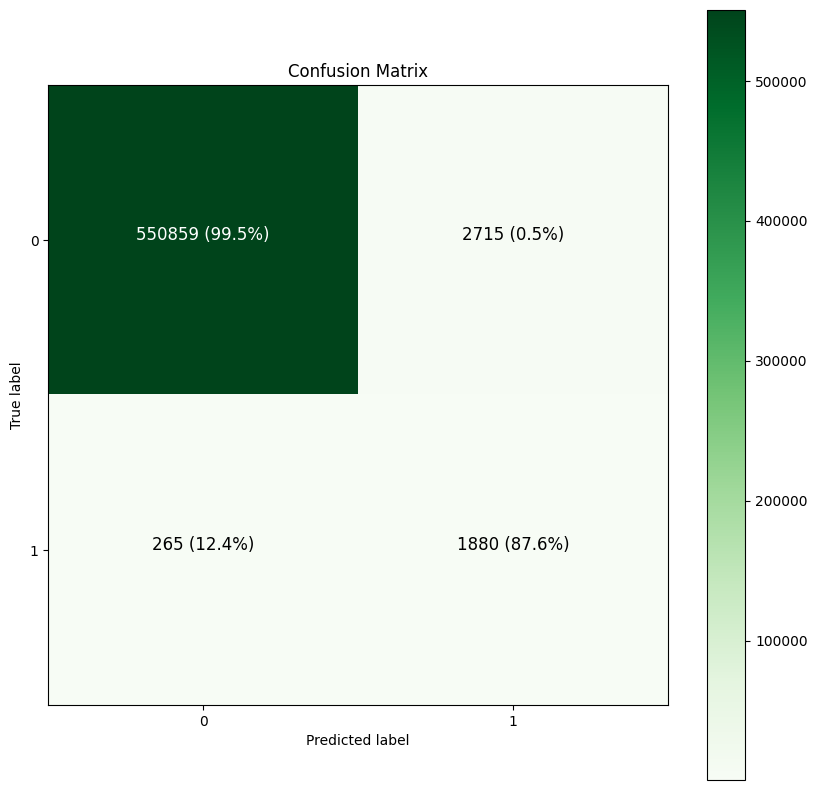

In [55]:
make_confusion_matrix(y_test, y_pred_test)

From confusion matrix, we can see that, some transactions were incorrectly classified as fraudulent by the model when they were actually non-fraudulent(Type 1 error). Even though the percentage is small (0.5%), in a large dataset, this could still represent a significant number of transactions. Model also fails to detect to idenfy some fradulent transactions with 12.4% (Type II error)


In [56]:
# Plot ROC Curve

def roc_pr_curve (y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

# Plot Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
    pr_auc_value = auc(recall_curve, precision_curve)

    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'Precision-Recall curve (AP = {pr_auc_value:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.show()
    


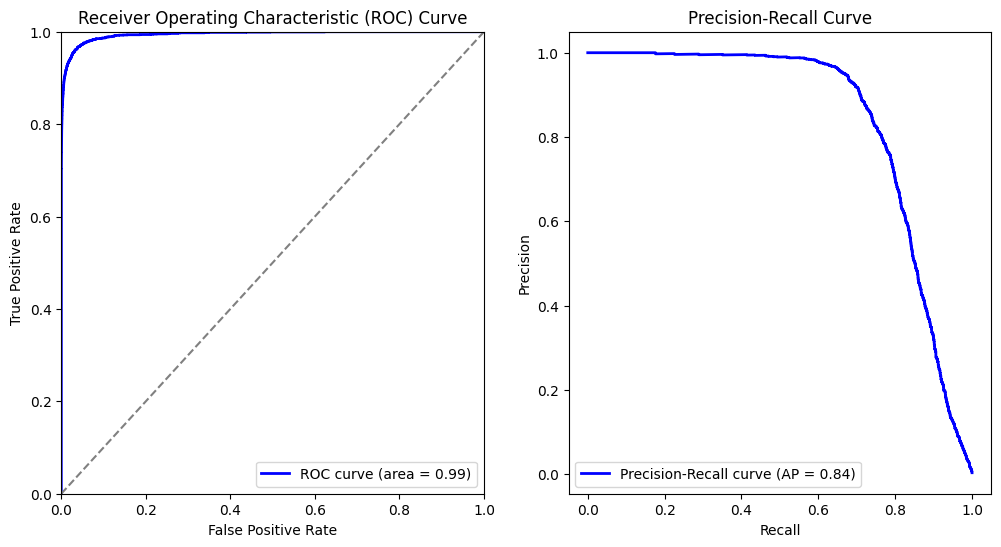

In [57]:
roc_pr_curve(y_test, y_scores)

From roc curve and precision recall curve we can see that the model is doing great job in classifying fraud/non fraud transactions and  maintains high precision even as recall increases, making it much more reliable for fraud detection. We see way better performance of the chosen model here due to fact that model are evalueated across all possible thresholds instead of XGB's default  threshold 0.5 

<Figure size 1000x800 with 0 Axes>

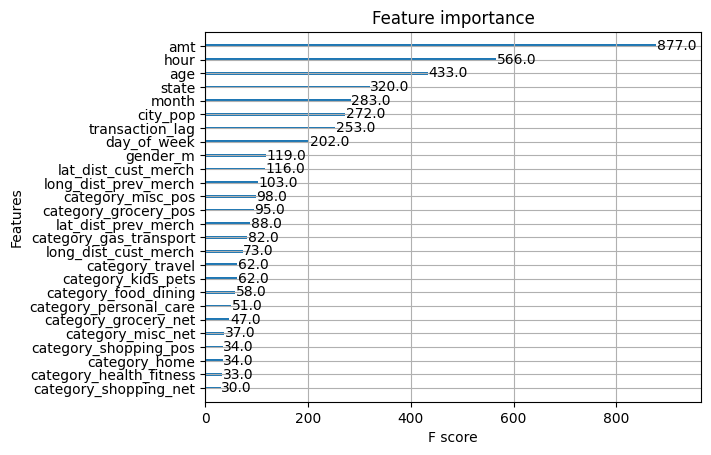

In [58]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

xgb_model = model_xgb.named_steps['xgbclassifier']

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight')  
plt.show()

From future importance plot, we can aslo see that transaction amt, hour, age, state features played a crucial role in predicting fradulent transactionons


Low precision I from chosen model where 0.5 default therhold used to predict class probabilities, is not desirable in credit fraud detection system, since it will definitely cause customer frustration. 

so I will leverage stacking classifier to benefit from capturing different patterns in the data by using better performed models from cross-validation as base models. I will use three different base models XGBClassifier, LightGBM, and Randomforest and meta model LogisticRegression(i.e it is common practice to use it) to combine predictions of the base model to see overall metrics, especially precision can furhter be improved

In [98]:
base_models = [
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('lgbm', LGBMClassifier(objective='binary',random_state=42,metric='binary_logloss'))
]

# Define the meta-model
meta_model = LogisticRegression(random_state=42)

# Create the stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3, n_jobs=-1)
 
pipeline = make_pipeline(
            SMOTE(sampling_strategy='minority', random_state=42),
            RandomUnderSampler(sampling_strategy='majority', random_state=42),
          stacked_model 
        )


X_train_transformed = transformer(X_train,y_train)
model = pipeline.fit(X_train_transformed,y_train)
X_test_preprocessed = transformer(X_test,y_test)

y_pred_test =  model.predict(X_test_preprocessed)

y_scores = model.predict_proba(X_test_preprocessed)[:, 1] 


        # Calculate metrics for the training set
metrics = pd.DataFrame({
         'Metric': ['ROC AUC', 'Precision', 'Recall', 'F1 Score',],
         'Values': [roc_auc_score(y_test, y_pred_test),
                        precision_score(y_test, y_pred_test),
                        recall_score(y_test, y_pred_test),
                        f1_score(y_test, y_pred_test)]}
                       )

print(metrics)

Preprocessor saved successfully!
[LightGBM] [Info] Number of positive: 1289169, number of negative: 1289169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6629
[LightGBM] [Info] Number of data points in the train set: 2578338, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/ulvijafarli/miniconda3/envs/main/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Info] Number of positive: 859446, number of negative: 859446
[LightGBM] [Info] Number of positive: 859446, number of negative: 859446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.659494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6629
[LightGBM] [Info] Number of data points in the train set: 1718892, number of used features: 26
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.648389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6629
[LightGBM] [Info] Number of data points in the train set: 1718892, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> inits

In [99]:
pickle.dump(model,open('model.pkl','wb'))
pickle_model = pickle.load(open('model.pkl','rb'))

In [101]:
X_test.head()

,category,amt,gender,state,city_pop,hour,age,day_of_week,month,lat_dist_cust_merch,long_dist_cust_merch,transaction_lag,long_dist_prev_merch,lat_dist_prev_merch
0,personal_care,2.86,m,sc,333497,12,52.0,6,6,0.020491,0.265214,1440.0,0.0,0.0
1,personal_care,29.84,f,ut,302,12,30.0,6,6,0.870202,0.475569,1440.0,0.0,0.0
2,health_fitness,41.28,f,ny,34496,12,49.0,6,6,0.177090,0.659611,1440.0,0.0,0.0
3,misc_pos,60.05,m,fl,54767,12,32.0,6,6,0.242698,0.063961,1440.0,0.0,0.0
4,travel,3.19,m,mi,1126,12,64.0,6,6,0.706248,0.867734,1440.0,0.0,0.0


As see in the output, The ROC AUC score is 0.883, which indicates that the model is quite good at distinguishing between fraudulent and non-fraudulent transactions. Precision is 87.82%, which means that when the model predicts a transaction as fraudulent, 87.82% of the time, it is correct. This is a strong precision score, indicating that the model has a relatively low rate of false positives (i.e., non-fraudulent transactions that are incorrectly classified as fraudulent). Recall is 76.64%, which indicates that the model correctly identifies 76.64% of actual fraudulent transactions. This means that 23.36% of fraudulent transactions are missed by the model (false negatives). While this recall rate is decent, there is room for improvement, as missing a significant portion of frauds could lead to substantial financial losses. An F1 Score of 0.8185 indicates that the model maintains a good balance between correctly identifying fraudulent transactions and avoiding false positives.

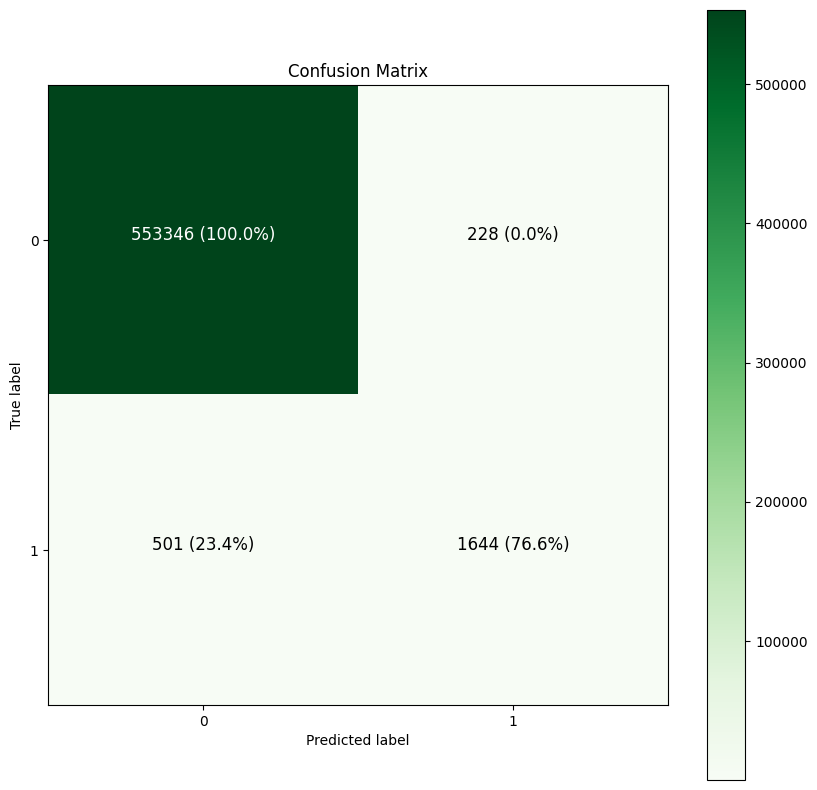

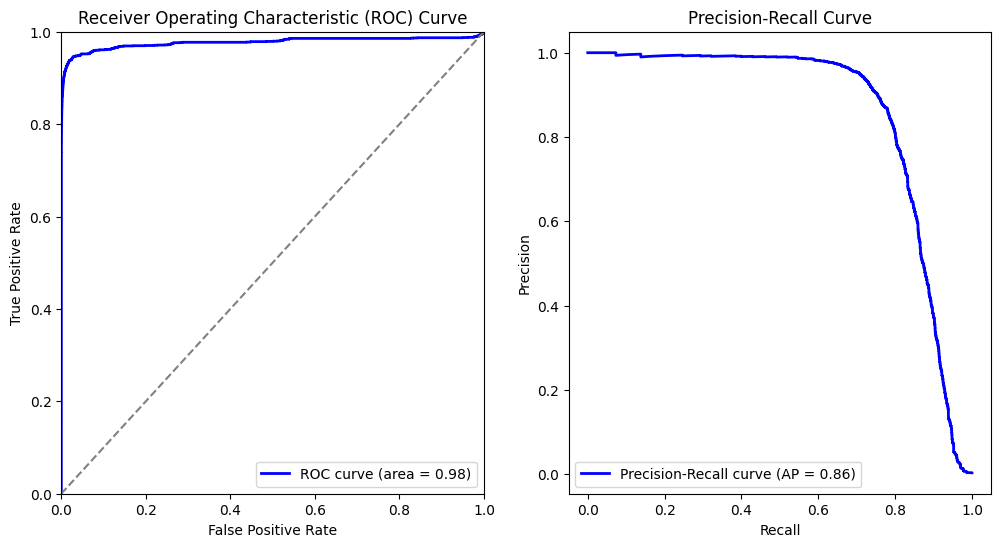

In [61]:
make_confusion_matrix(y_test, y_pred_test)

roc_pr_curve(y_test, y_scores)

From the confusion matrix, we can say that the model predicted 76%.6 of fradulent transactions correctly, but there are 23.4 of transactions that model falsely identified as non- fraduelent. The model predicted 100% of legitimate transactions correctly and there are only few transactions that incorrectly classified as fradulent. 

The area under the ROC curve (AUC) is 0.98, which is almost perfect. This means that the model has a high true positive rate while keeping the false positive rate low, which is crucial for fraud detection. A precision-recall AUC of 0.86 indicates that the model is generally effective at identifying fraudulent transactions while keeping false positives at a reasonable level. We again see way better performance of the chosen model in the graphs  due to fact that model are evalueated across all possible thresholds instead of stacking classifier's default threshold which is 0.5 

Based on output, I would use Stacking Classifier as a final model to predict fradulent transactions due to its performance. If given more time to work on this challenge, I would also focus on exploring more advanced modeling techniques, particularly in the realm of deep learning. While I have already evaluated a range of models, including ensemble methods, and successfully implemented a stacking classifier with high-performing models like Random Forest, XGBoost, and LightGBM, I also would explore Recurrent Neural Networks (RNNs), particularly Long Short-Term Memory (LSTM) networks. These are well-suited for time-series data, such as transaction sequences, and could help capture patterns over time that indicate fraudulent behavior, potentially improving the model's ability to detect fraud in more complex scenarios

THE END